In [24]:
import os
import obspy
from obspy import read
from obspy.core import UTCDateTime

In [5]:
data_dir = '/home/b/.seisml/data/triggered_tremor_raw/'
pos_dir = os.path.join(data_dir, 'positive/Japan_20120411/positive')
neg_dir = os.path.join(data_dir, 'negative')
positive_files = os.listdir(pos_dir)
negative_file = os.listdir(neg_dir)

In [27]:
def trim_positive(trace, rate=100, seconds=1000, speed=4.0):
    
    try:
        dist = trace.stats.sac.dist
    except:
        print('no dist')
        return None
    
    sampling_rate = trace.stats.sampling_rate
    starttime = trace.stats.starttime
    endtime = trace.stats.endtime
    
    if endtime - starttime < seconds:
        return None

    new_start_time = starttime + (dist/speed)

    if endtime > (new_start_time + seconds):
        new_end_time = new_start_time + seconds
    else:
        new_start_time = endtime - seconds
        new_end_time = endtime

    trimmed = trace.trim(new_start_time, new_end_time).detrend('demean')
    
    if rate >= sampling_rate:
        return trimmed.resample(rate)[:rate*seconds]
    else:
        decimate_factor = int(sampling_rate / rate)
        return trimmed.decimate(decimate_factor)[:rate*seconds]



In [34]:
def trim_negative(trace, rate=100, seconds=1000, start_sec=400):
    starttime = trace.stats.starttime
    endtime = trace.stats.endtime
    sampling_rate = trace.stats.sampling_rate
    
    if endtime - starttime < seconds:
        return None
    elif endtime - starttime > start_sec + seconds:
        trimmed = trace.trim(starttime + start_sec, starttime + (start_sec + seconds))
    else:
        trimmed = trace.trim(endtime - seconds, endtime)
        
    trimmed = trimmed.detrend('demean')
    
    if rate >= sampling_rate:
        return trimmed.resample(rate)[:rate*seconds]
    else:
        decimate_factor = int(sampling_rate / rate)
        return trimmed.decimate(decimate_factor)[:rate*seconds]
        

Hi-net.N.BEWH..N | 2012-04-11T08:33:38.000000Z - 2012-04-11T09:40:17.990000Z | 100.0 Hz, 400000 samples


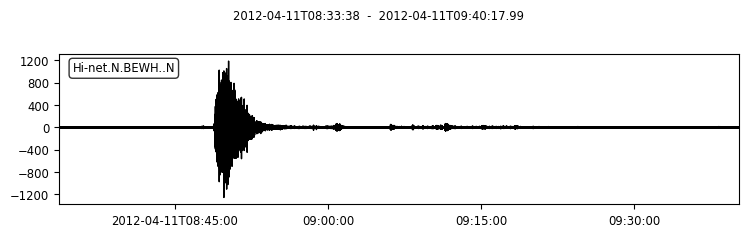

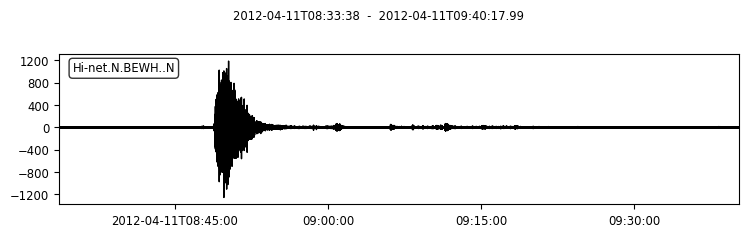

In [29]:
pos_stream = read(os.path.join(pos_dir, positive_files[0]))
print(pos_stream[0])
pos_stream.plot()

(20000,)


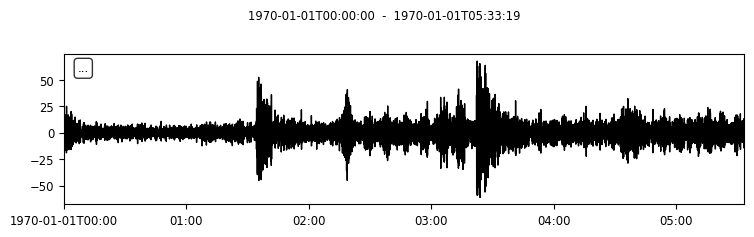

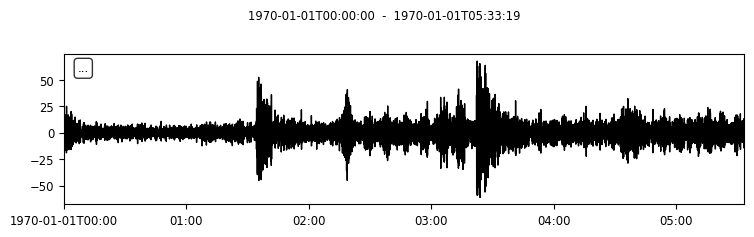

In [30]:
new_pos = trim_positive(pos_stream[0], rate=20)
print(new_pos.shape)
obspy.Trace(new_pos).plot()

IU.PAB.00.BHZ | 2011-03-04T06:00:00.019538Z - 2011-03-04T06:29:59.969538Z | 20.0 Hz, 36000 samples


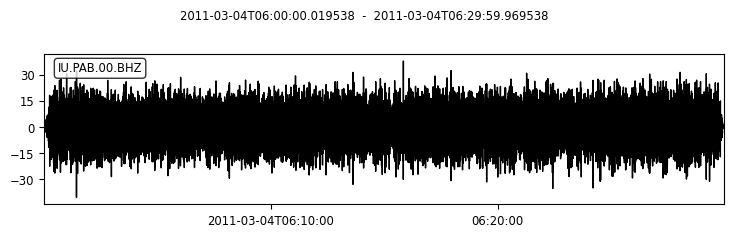

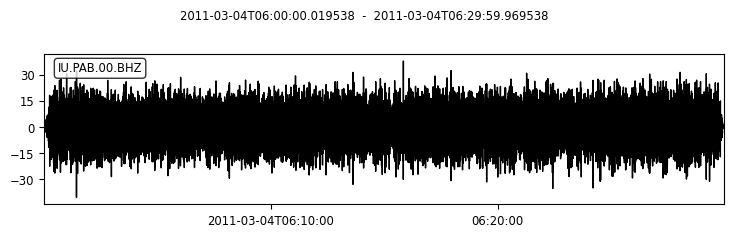

In [35]:
neg_stream = read(os.path.join(neg_dir, negative_file[0]))
print(neg_stream[0])
neg_stream[0].plot()

20.0
(20000,)


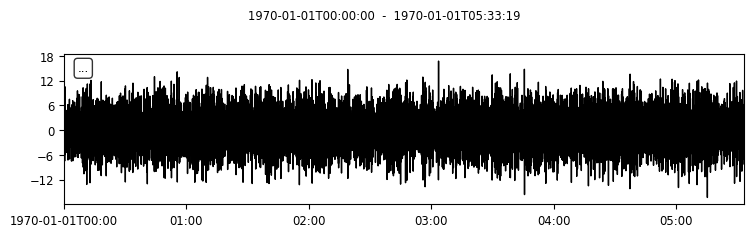

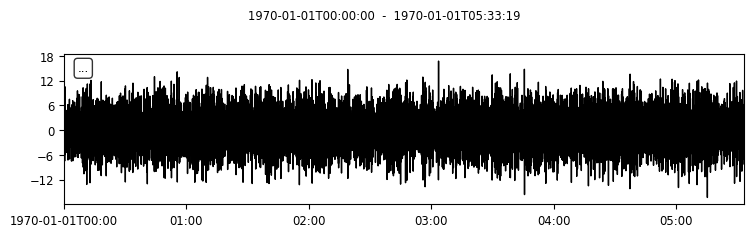

In [38]:
print(neg_stream[0].stats.sampling_rate)
trimmed_neg = trim_negative(neg_stream[0], rate=20)
print(trimmed_neg.shape)
obspy.Trace(trimmed_neg).plot()

## Preprocess and save data

In [41]:
import pickle, h5py

data_dir = '/home/b/.seisml/data/triggered_tremor_raw/'
new_data_dir = '/home/b/.seisml/data/triggered_tremor_processed/'
pos_dir = os.path.join(data_dir, 'positive/')
neg_dir = os.path.join(data_dir, 'negative')

if not os.path.exists(new_data_dir):
    os.mkdir(new_data_dir)

samples = []
labels = []

## negative

In [43]:
negative_files = os.listdir(neg_dir)

for f in negative_files:
    tr = read(os.path.join(neg_dir, f))[0]
    data = trim_negative(tr, rate=20)
    if data is not None:
        pickle.dump(
            data, 
            open(os.path.join(new_data_dir, 'negative_{}.p'.format(f)), 'wb')
        )
        samples.append(data)
        labels.append(0)

In [44]:
positive_dirs = os.listdir(pos_dir)

for dir in positive_dirs:
    for f in list(filter(lambda x: x.split('.')[-1].lower() == 'sac' and x[0] != '.', os.listdir(os.path.join(pos_dir, dir, 'positive')))):
        tr = read(os.path.join(pos_dir, dir, 'positive', f))[0]
        data = trim_positive(tr, rate=20)
        if data is not None:
            pickle.dump(
                data, 
                open(os.path.join(new_data_dir, 'positive_{}.p'.format(f)), 'wb')
            )
            samples.append(data)
            labels.append(1)

no dist
no dist
no dist
no dist
no dist
no dist


In [45]:
import numpy as np

samples = np.vstack(samples)
labels = np.vstack(labels)

randomize = np.arange(len(labels))
np.random.shuffle(randomize)

In [46]:
hf = h5py.File('triggered_tremor_sample.h5', 'w')

hf.create_dataset('X', data=samples[randomize])
hf.create_dataset('y', data=labels[randomize])

hf.close()

In [47]:
import json

metadata = {
    'size': len(labels),
    'positive': int(np.sum(labels)),
    'negative': len(labels) - int(np.sum(labels)),
    'sample_rate': '20Hz',
    'sample_size': int(samples.shape[-1]) 
}

print(metadata)

with open('metadata.json', 'w') as f:
    json.dump(metadata, f)

{'size': 717, 'positive': 327, 'negative': 390, 'sample_rate': '20Hz', 'sample_size': 20000}


In [93]:
import json

metadata = {
    'size': len(labels),
    'positive': int(np.sum(labels)),
    'negative': len(labels) - int(np.sum(labels)),
    'sample_rate': '100Hz',
    'sample_size': int(samples.shape[-1]) 
}

print(metadata)

with open('metadata.json', 'w') as f:
    json.dump(metadata, f)

{'size': 717, 'positive': 327, 'negative': 390, 'sample_rate': '100Hz', 'sample_size': 100000}
